In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv
/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv


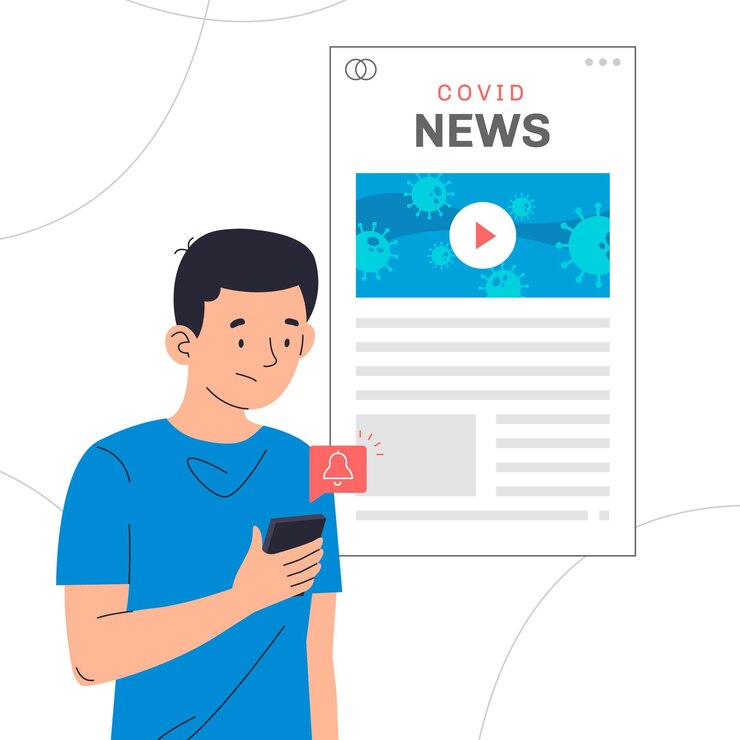

# Summary🖋️
Fake news refers to deliberately fabricated or misleading information presented as factual news. It often aims to deceive readers or viewers for various purposes, such as influencing opinions, spreading propaganda, or generating revenue through clicks. Detecting fake news is crucial in combating misinformation and maintaining the integrity of journalism and public discourse. Deep learning techniques, such as natural language processing and neural networks, can be effective in identifying patterns and features indicative of fake news, helping to automate the process of verification and fact-checking.

# What you will find in this notebook📒-
1. Utilizing **LSTM (Long Short-Term Memory) RNN** for Fake News Detection.
2. Feature embedding is constructed before LSTM, facilitating data representation.
3. Preprocessing includes **stemming
SnowballStemmer
regex** using **stemming
SnowballStemmer
regex** and **stemming
SnowballStemmer
regex** cleaning.
4. One-hot encoding by **Keras** prepares textual data for LSTM input.
5. Adam optimizer and **binary_crossentropy** loss function are employed during model compilation.
6. Model performance evaluation includes **classification report and confusion matrix**.
7. Determination of the optimal **threshold value** for prediction refinement.

# Let's Dive In🏊‍

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
import nltk
from nltk.stem.snowball import SnowballStemmer
import regex as re
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords


2024-02-21 13:29:08.894198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 13:29:08.894314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 13:29:09.012260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# download some packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# datasets
df_fake = pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv")
df_true = pd.read_csv("/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv")

In [5]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
# label them seperately 
df_true['status'] = 0
df_fake['status'] = 1

In [8]:
# merge and remove unnecessary columns
df = pd.concat([df_true,df_fake])
df.drop(['subject','text','date'],axis=1,inplace=True)

* Since we are going to build model only based on the title feature, hence dropped text, date , subject

In [9]:
# let's blend the smoothie
random_indexes = np.random.randint(0,len(df),len(df))
df = df.iloc[random_indexes].reset_index(drop=True)

## Text analysis

In [10]:
pd.set_option('display.max_colwidth', 500)
random = np.random.randint(0,len(df),20)
df.iloc[random]

,title,status
36981,FOX NEWS REPORTER ASKS MAYOR Why She’s Using Taxpayer Money To Sue Family For Epic Christmas Light Display [VIDEO],1
29681,Iran ‘Will Respond’ if US Moves to Designate Revolutionary Guard as ‘Terrorist Group’,1
7091,"For 'Apprentice' insiders, Trump's 2016 bid has echoes of reality TV",0
31084,DETROIT COP UNDER FIRE FOR FACEBOOK POST: “The only racists here are the piece of (expletive) Black Lives Matter terrorists and their supporters” [VIDEO],1
27434,WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video],1
31686,EGYPTIAN COURT SENTENCES MUSLIM BROTHERHOOD LEADER AND 13 OTHERS TO DEATH AND LEADER’S “Peaceful” U.S.-Egyptian Brother To Life In Prison,1
18290,WATCH: MSNBC’S HATE-FILLED LIBERAL Host Chris Matthews Makes Joke About President Trump Assassinating His Son-In-Law…No Media Outrage,1
16031,"Trump Tries To Shake Polish First Lady’s Hand, She Refuses To Touch Him (VIDEO)",1
17248,Orlando killer expressed support for multiple Islamist groups,0
41426,"REPORT: Trump And Companies Tied To Over 100 Lawsuits, Tax Evasion",1


* work needs to be done on data before feeding to neural network-
1. Remove punctuations eg ""
2. Convert uppercase to lowercase
3. No need to apply stemming, otherwise it will just shorten the word unnecessary
4. Apply lemmatization
5. Remove all the stopwords
6. Finally make vocabulary after completion of 5 steps

In [11]:
# Null values
df.isnull().sum()

title     0
status    0
dtype: int64

In [12]:
# longest sentence length 
def longest_sentence_length(text):
  return len(text.split())

df['maximum_length'] = df['title'].apply(lambda x : longest_sentence_length(x))
print('longest sentence having length -')
max_length = max(df['maximum_length'].values)
print(max_length)

longest sentence having length -
42


In [13]:
# Text cleaning
text_cleaning = "\b0\S*|\b[^A-Za-z0-9]+"

def preprocess_filter(text, stem=False):
  text = re.sub(text_cleaning, " ",str(text.lower()).strip())
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        stemmer = SnowballStemmer(language='english')
        token = stemmer.stem(token)
      tokens.append(token)
  return " ".join(tokens)

* The regular expression pattern removes non-alphanumeric characters and digits, enhancing text cleanliness for subsequent analysis.
* Text preprocessing function standardizes text by converting it to lowercase, removing stop words, and optionally applying stemming, facilitating effective natural language processing.
* Stemming simplifies words to their root forms, aiding in capturing underlying semantic meanings and improving search accuracy.
* Removal of stop words reduces noise in text data, focusing on informative words and enhancing the quality of subsequent analysis.

In [14]:
# Word embedding with pre padding 
def one_hot_encoded(text,vocab_size=5000,max_length = 40):
    hot_encoded = one_hot(text,vocab_size)
    return hot_encoded

In [15]:
# word embedding pipeline
def word_embedding(text):
    preprocessed_text=preprocess_filter(text)
    return one_hot_encoded(preprocessed_text)

In [16]:
# Creating NN Model
embedded_features = 40
model = Sequential()
model.add(Embedding(5000,embedded_features,input_length = max_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy',optimizer= 'adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 42, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256501 (1001.96 KB)
Trainable params: 256501 (1001.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


* The model utilizes a vocabulary size of 5000, reflecting the extensive nature of the dataset and the need to handle a wide range of words effectively.
* By embedding input tokens into 40-dimensional vectors, the model captures nuanced semantic relationships, crucial for understanding the complex language patterns present in the dataset.
* Leveraging an LSTM layer with 100 units, the model effectively learns from the extensive sequential data, ensuring it captures long-term dependencies and context effectively.
* With a final dense layer employing a sigmoid activation function, the model delivers binary classification predictions, adeptly classifying the vast and varied dataset with accuracy.

In [17]:
# One hot encoded title
one_hot_encoded_title =df['title'].apply(lambda x : word_embedding(x)).values

In [18]:
# padding to make the size equal of the sequences
padded_encoded_title = pad_sequences(one_hot_encoded_title,maxlen=max_length,padding = 'pre')

In [19]:
# Splitting 
X = padded_encoded_title
y = df['status'].values
y = np.array(y)

# shapes
print(X.shape)
print(y.shape)

(44898, 42)
(44898,)


In [20]:
# shape and size
print('X shape {}'.format(X.shape))
print('y shape {}'.format(y.shape))

X shape (44898, 42)
y shape (44898,)


In [21]:
# Splitting into training, testing
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 42)

# Shape and size of train and test dataset
print('X train shape {}'.format(X_train.shape))
print('X test shape {}'.format(X_test.shape))
print('y train shape {}'.format(y_train.shape))
print('y test shape {}'.format(y_test.shape))

X train shape (33673, 42)
X test shape (11225, 42)
y train shape (33673,)
y test shape (11225,)


In [22]:
# Model training
# training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64)

Epoch 1/15


I0000 00:00:1708522170.522540      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


527/527 [==============================] - 23s 38ms/step - loss: 0.1991 - accuracy: 0.9167 - val_loss: 0.1147 - val_accuracy: 0.9564
Epoch 2/15
527/527 [==============================] - 5s 10ms/step - loss: 0.0739 - accuracy: 0.9742 - val_loss: 0.0976 - val_accuracy: 0.9666
Epoch 3/15
527/527 [==============================] - 4s 7ms/step - loss: 0.0418 - accuracy: 0.9866 - val_loss: 0.1018 - val_accuracy: 0.9691
Epoch 4/15
527/527 [==============================] - 4s 7ms/step - loss: 0.0238 - accuracy: 0.9928 - val_loss: 0.1234 - val_accuracy: 0.9657
Epoch 5/15
527/527 [==============================] - 4s 7ms/step - loss: 0.0151 - accuracy: 0.9957 - val_loss: 0.1598 - val_accuracy: 0.9674
Epoch 6/15
527/527 [==============================] - 4s 7ms/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.1558 - val_accuracy: 0.9678
Epoch 7/15
527/527 [==============================] - 4s 7ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.1787 - val_accuracy: 0.9695
Epoch 8/15
527

## Evaluation

In [23]:
# setting threshold value 
def best_threshold_value(thresholds:list,X_test):
    accuracies = []
    for thresh in thresholds:
        ypred =model.predict(X_test)
        ypred = np.where(ypred> thresh,1,0)
        accuracies.append(accuracy_score(y_test,ypred))
    return pd.DataFrame({
        'Threshold': thresholds,
        'Accuracy' : accuracies
    })

In [24]:
best_threshold_value([0.4,0.5,0.6,0.7,0.8,0.9], X_test)

351/351 [==============================] - 1s 2ms/step


,Threshold,Accuracy
0,0.4,0.965880
1,0.5,0.965969
2,0.6,0.966325
3,0.7,0.966860
4,0.8,0.966860
5,0.9,0.966771


* Not much difference in accuray 
* But the most suitable threshold value we have got is **0.4**

In [25]:
# Predictino value at threshold 0.4
y_pred = model.predict(X_test)
y_pred = np.where(y_pred >0.4, 1, 0)

351/351 [==============================] - 1s 2ms/step


In [26]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_pred,y_test))
print('----------------')
print('Classification report')
print(classification_report(y_pred,y_test))

Confusion matrix
[[5045  153]
 [ 230 5797]]
----------------
Classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5198
           1       0.97      0.96      0.97      6027

    accuracy                           0.97     11225
   macro avg       0.97      0.97      0.97     11225
weighted avg       0.97      0.97      0.97     11225



* The model performs well in both classes, with high precision, recall, and F1-score, suggesting robustness in classification.
* There is no significant imbalance in performance between the two classes, as evidenced by similar metrics for both classes.
* The model's overall performance is excellent, achieving high accuracy on the dataset.

## Predictions

In [27]:
# input generator 
def prediction_input_processing(text):
    encoded = word_embedding(text)
    padded_encoded_title = pad_sequences([encoded],maxlen=max_length,padding = 'pre')
    output = model.predict(padded_encoded_title)
    output = np.where(0.4>output,1,0)
    if output[0][0] == 1:
        return 'Yes this News is fake'
    return 'No, It is not fake'   
    

In [28]:
# predictions
prediction_input_processing('Americans are more concerned over Indians fake open source contribution')

1/1 [==============================] - 0s 20ms/step


'Yes this News is fake'

In [29]:
news = 'Trump Just Sent Michelle Obama a Bill She will Never Be able to pay in her lifetime'
prediction_input_processing(news)

1/1 [==============================] - 0s 19ms/step


'No, It is not fake'

__________________________________________________________

# आभारं तव कालाय। भगवान् त्वां धन्यतां प्रददातु।🙏🙏

________________________________________________________________